In [1]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

In [2]:
llm = ChatOpenAI(model="gpt-4o")

In [3]:
# Schema for structured output
from pydantic import BaseModel, Field
from langchain_community.tools import TavilySearchResults


class SearchQuries(BaseModel):
    search_query: list = Field(
        None, description="List of Queries that are optimized for web search."
    )
    justification: list = Field(
        None, description="Why each query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuries)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")


# Define a tool
tavily_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([tavily_tool])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke(
    "nvidia 주가 하락의 원인이 된 대상 이름이 뭐야?그리고 그 대상에 대한 정보 알려줘"
)

# Get the tool call
msg.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'Nvidia 주가 하락 원인'},
  'id': 'call_DTmXVQBRMHfDoq4Q6PshktlX',
  'type': 'tool_call'}]

In [4]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


class SearchQury(BaseModel):
    search_query: str = Field(
        None, description="Query that is optimized for web search."
    )
    justification: str = Field(
        None, description="Why query is relevant to the user's request."
    )


class Reference(BaseModel):
    """Model for a reference"""

    title: str = Field(description="The title of the reference.")
    url: str = Field(description="The url of the reference.")


# Graph state
class State(TypedDict):
    search_queries: list[SearchQury]
    combined_output: str



In [5]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

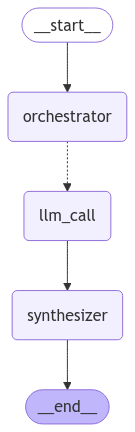

In [6]:
from langgraph.constants import Send
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
checkpointer = MemorySaver()

orchestrator_worker = orchestrator_worker_builder.compile(checkpointer=checkpointer)

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [7]:
import asyncio
from typing import Any, Dict, List, Callable
from langchain_core.runnables import RunnableConfig
from langgraph.graph.state import CompiledStateGraph


async def astream_graph(
    graph: CompiledStateGraph,
    inputs: Dict[str, Any],
    config: RunnableConfig,
    node_names: List[str] = [],
    callback: Callable[[Dict[str, str]], None] = None,
):
    """
    LangGraph의 실행 결과를 비동기 방식으로 스트리밍하여 출력하는 함수입니다.

    매개변수:
    - graph (CompiledStateGraph): 실행할 컴파일된 LangGraph 객체
    - inputs (dict): 그래프에 전달할 입력값 딕셔너리
    - config (RunnableConfig): 실행 설정
    - node_names (List[str], optional): 출력할 노드 이름 목록 (빈 리스트면 모든 노드 출력)
    - callback (Callable[[Dict[str, str]], None], optional): 각 청크 처리를 위한 콜백 함수 (기본값: None)
      콜백 함수는 {"node": str, "content": str} 형태의 딕셔너리를 인자로 받습니다.

    반환값:
    - None: 함수는 스트리밍 결과를 출력만 하고 반환값은 없습니다.
    """
    prev_node = ""
    async for chunk_msg, metadata in graph.astream(
        inputs, config, stream_mode="messages"
    ):
        curr_node = metadata["langgraph_node"]

        # node_names가 비어있거나 현재 노드가 node_names에 포함된 경우에만 처리
        if not node_names or curr_node in node_names:
            if callback:
                callback({"node": curr_node, "content": chunk_msg.content})
            else:
                # 노드가 변경될 때마다 헤더를 출력
                if curr_node != prev_node:
                    print("\n" + "=" * 60)
                    print(f"🔹 Node: \033[1;34m{curr_node}\033[0m 🔹")
                    print("=" * 60)

                # 콘텐츠를 보기 좋게 출력
                print(chunk_msg.content, end="", flush=True)

            prev_node = curr_node

In [13]:
import asyncio
from typing import Any, Dict, List, Callable
from langchain_core.runnables import RunnableConfig
from langgraph.graph.state import CompiledStateGraph


async def astream_graph(
    graph: CompiledStateGraph,
    inputs: Dict[str, Any],
    config: RunnableConfig,
    node_names: List[str] = [],
    callback: Callable[[Dict[str, str]], None] = None,
):
    """
    LangGraph의 실행 결과를 비동기 방식으로 스트리밍하여 출력하는 함수입니다.

    매개변수:
    - graph (CompiledStateGraph): 실행할 컴파일된 LangGraph 객체
    - inputs (dict): 그래프에 전달할 입력값 딕셔너리
    - config (RunnableConfig): 실행 설정
    - node_names (List[str], optional): 출력할 노드 이름 목록 (빈 리스트면 모든 노드 출력)
    - callback (Callable[[Dict[str, str]], None], optional): 각 청크 처리를 위한 콜백 함수 (기본값: None)
      콜백 함수는 {"node": str, "content": str} 형태의 딕셔너리를 인자로 받습니다.

    반환값:
    - None: 함수는 스트리밍 결과를 출력만 하고 반환값은 없습니다.
    """
    prev_node = ""
    async for chunk_msg, metadata in graph.astream(
        inputs, config, stream_mode="messages"
    ):
        curr_node = metadata["langgraph_node"]

        # node_names가 비어있거나 현재 노드가 node_names에 포함된 경우에만 처리
        if not node_names or curr_node in node_names:
            if callback:
                callback({"node": curr_node, "content": chunk_msg.content})
            else:
                # 노드가 변경될 때마다 헤더를 출력
                if curr_node != prev_node:
                    print("\n" + "=" * 60)
                    print(f"🔹 Node: {curr_node} 🔹")
                    print("=" * 60)

                # 쿼리 정보가 있으면 출력
                tool_calls = chunk_msg.additional_kwargs.get("tool_calls", [])
                if tool_calls:
                    # print(f"🔍 Query: ", end="")
                    for tool_call in tool_calls:
                        query = tool_call.get("function", {}).get("arguments", "")
                        if query:

                            print(f"\033[1;33m{query}\033[0m", end="", flush=True)
                else:
                    # 쿼리 정보가 없으면 content 출력
                    content = chunk_msg.content.strip()
                    if content:
                        print(f"{content}", end="", flush=True)

            prev_node = curr_node

In [14]:
config = {
    "configurable": {
        "thread_id": 1,  # temporary thread ID for testing
    },
}

inputs = State(
    topic="Create a report on LLM scaling laws",
    sections = [],
    completed_sections = [],
    final_report = ""
    
)

In [16]:
await astream_graph(orchestrator_worker, inputs, config=config)


🔹 Node: orchestrator 🔹
{"sections":[{"name":"Introduction to LLM Scaling Laws","description":"This section introduces the concept of scaling laws in the context of large language models (LLMs). It will cover the basics of what scaling laws are and why they are important in the development and improvement of LLMs."},{"name":"Historical Development of Scaling Laws","description":"This section delves into the history and evolution of scaling laws in machine learning, particularly focusing on how they have been applied to language models. It will highlight key research milestones and breakthroughs."},{"name":"Key Principles of LLM Scaling Laws","description":"This section explores the fundamental principles that underpin scaling laws in LLMs, including the mathematical and theoretical frameworks used to understand these laws. It will also cover the key variables and metrics involved in scaling LLMs."},{"name":"Practical Implications of Scaling Laws","description":"This section discusses t

In [ ]:
from IPython.display import Markdown

Markdown(orchestrator_worker.get_state(config).values["final_report"])

## Introduction to LLM Scaling Laws

In the rapidly evolving field of artificial intelligence, Large Language Models (LLMs) have emerged as powerful tools for natural language processing and understanding. A crucial concept underpinning the development and optimization of these models is the notion of scaling laws. Scaling laws, in the context of LLMs, refer to the empirical relationships that describe how the performance of a model improves as its size—measured in parameters, data, and compute resources—increases.

### A Brief History

The concept of scaling laws was first systematically explored in the realm of deep learning through the pioneering work on neural networks. However, it gained significant traction with the advent of LLMs, particularly marked by the development of models such as GPT-2 and GPT-3 by OpenAI. These models demonstrated that larger models trained on more data tend to perform better across a wide range of tasks, a phenomenon that was quantitatively captured by scaling laws.

The seminal paper by Kaplan et al. (2020) provided a detailed examination of these scaling laws, showing that model performance, measured in terms of loss, improves predictably as the number of parameters, the size of the dataset, and the amount of compute used during training increase. This work laid the foundation for understanding how to efficiently allocate resources in developing more capable models.

### Importance for AI Development

Scaling laws are instrumental in guiding the future of AI development for several reasons:

1. **Predictive Power**: They allow researchers and engineers to predict the performance gains from increasing model size and compute resources, facilitating informed decisions about resource allocation.

2. **Efficiency**: Understanding scaling laws helps in identifying the diminishing returns of scaling, thus preventing unnecessary resource expenditure and optimizing the process of model training.

3. **Benchmarking**: These laws provide a benchmark for comparing different models and architectures, helping to establish a baseline for what can be achieved with given resources.

4. **Innovation**: By elucidating the relationship between model size, data, and performance, scaling laws encourage the exploration of new architectures and training methodologies that might break away from existing patterns, leading to innovative advancements.

In conclusion, scaling laws represent a cornerstone in the development of LLMs, offering a theoretical and empirical framework that guides the strategic scaling of AI models. As the field continues to advance, understanding and leveraging these laws will be essential for pushing the boundaries of what AI can accomplish.

---

## Mathematical Foundation of Scaling Laws

Scaling laws in machine learning and artificial intelligence describe how various elements such as model size, data quantity, computational resources, and performance are interrelated. Understanding these relationships is crucial for effectively designing and optimizing models. This section explores the mathematical principles that govern these scaling laws, providing insight into their foundational aspects.

### Model Size and Performance

The relationship between model size and performance often follows a power-law distribution. Mathematically, this can be expressed as:

\[ P \propto S^\alpha \]

where \( P \) represents performance metrics such as accuracy or loss, \( S \) denotes the size of the model (often measured in parameters), and \( \alpha \) is a scaling exponent. This relationship suggests that increasing model size can lead to improved performance, but the rate of improvement diminishes as the model grows larger. This phenomenon is linked to the capacity of the model to capture complex patterns in data, which is initially enhanced with more parameters but eventually encounters diminishing returns.

### Data Quantity and Model Performance

Similarly, the quantity of data available for training is crucial for model performance. The law governing this relationship can be expressed as:

\[ P \propto D^\beta \]

where \( D \) is the amount of data and \( \beta \) is another scaling exponent. This relationship highlights that more data can lead to better model performance, as it allows the model to learn more robust and generalizable features. However, like model size, the benefits of additional data tend to decrease beyond a certain point, where the model has effectively captured the underlying data distribution.

### Computation and Efficiency

Scaling laws also encompass the computational resources required to train and deploy models. The computational cost \( C \) can be modeled as:

\[ C \propto S \times D \]

This equation implies a direct proportionality between computational resources and both model size and data quantity. Efficient utilization of computational resources often involves optimizing hyperparameters and leveraging techniques like model pruning or quantization to reduce unnecessary computations without significantly sacrificing performance.

### Interplay of Model Size, Data, and Computation

The interplay between model size, data, and computation can be effectively illustrated through the concept of isoresource curves, where performance is plotted against a fixed budget of computational resources. These curves help in understanding trade-offs and making informed decisions about where to allocate resources—whether to increase model size, gather more data, or optimize computational efficiency.

### Implications of Scaling Laws in AI

The scaling laws provide a framework for predicting how changes in model size, data, or computation will affect performance. They are instrumental in guiding the development of large-scale models, such as those used in natural language processing and computer vision, by highlighting the potential benefits and limitations of scaling different components. Moreover, these laws underscore the importance of balancing model architecture, data strategy, and computational budget to achieve optimal results.

In conclusion, the mathematical foundations of scaling laws reveal the intrinsic connections between key factors that drive model performance. By understanding and leveraging these principles, researchers and practitioners can make more strategic decisions in the design and deployment of AI systems.

---

## Empirical Observations in LLM Scaling

In recent years, the scaling of large language models (LLMs) has provided a wealth of empirical data that underscores the theoretical scaling laws posited by researchers. This section delves into the observed patterns and outcomes of scaling LLMs, drawing from a selection of recent studies and projects that have contributed to our understanding of how these models behave as they increase in size and complexity.

### Observed Scaling Patterns

One of the most consistent observations in LLM scaling is the relationship between model size, computational power, and performance. Kaplan et al. (2020) outlined foundational scaling laws that demonstrate predictable improvements in model performance with increased parameters, compute budget, and dataset size. These laws have been empirically validated across multiple studies, confirming that larger models generally yield better performance on a range of natural language processing (NLP) tasks.

For instance, OpenAI's GPT series illustrates a clear trajectory of improvement with each successive model. GPT-3, with 175 billion parameters, significantly outperformed its predecessors across diverse benchmarks, showcasing improved language understanding and generation capabilities. This trend is further corroborated by the release of GPT-4, which, although specifics remain undisclosed, is purported to exhibit even greater enhancements in performance metrics.

### Case Studies and Research Findings

1. **Chinchilla Scaling Laws**: Hoffmann et al. (2022) presented the Chinchilla scaling laws, which refined previous models by emphasizing the importance of balancing model size and training data. Their experiments demonstrated that underutilizing data relative to model size leads to inefficiencies, suggesting that optimal performance is achieved by aligning the two variables. This insight has steered subsequent model training approaches towards a more data-efficient paradigm.

2. **DeepMind's Gopher**: Gopher, a model developed by DeepMind with 280 billion parameters, showcased the practical application of scaling laws. The research highlighted how scaling not only improved traditional NLP task performance but also enabled novel capabilities such as better handling of factual inaccuracies, a prevalent challenge in earlier models.

3. **EleutherAI's GPT-NeoX**: EleutherAI's GPT-NeoX project serves as another example where empirical scaling is explored. Their open-source efforts aim to replicate and expand upon the findings of proprietary models, providing a transparent platform for validating scaling laws. Preliminary results indicate that, consistent with previous studies, increasing model size leads to qualitative improvements in output.

### Implications of Scaling

The empirical evidence supporting scaling laws has profound implications for the future of AI research and development. As models continue to grow, the costs associated with their training and deployment also increase, necessitating innovations in hardware and energy efficiency. Moreover, the scaling of LLMs is accompanied by challenges such as ethical concerns, bias amplification, and data privacy issues, which must be addressed to ensure the responsible advancement of AI technologies.

### Conclusion

Empirical observations in LLM scaling confirm the theoretical predictions of scaling laws, revealing a predictable pattern of performance gains with model size. As research continues to refine these laws and explore their limits, the insights gained will be crucial for guiding the development of future models, optimizing resource allocation, and addressing the broader impacts of scaling AI systems. The ongoing work in this field promises to unlock new frontiers in machine intelligence, reshaping our interaction with technology in unprecedented ways.

---

## Impact of Scaling Laws on Model Performance

Scaling laws have become a crucial aspect in the development and optimization of large language models (LLMs), significantly influencing their performance across various dimensions including accuracy, efficiency, and generalization capabilities. This section delves into how these laws shape the capabilities of LLMs and the implications for future developments in artificial intelligence.

### Accuracy

Scaling laws suggest that as the size of a model — typically defined by the number of parameters — increases, so does the model's accuracy on various tasks. Larger models have demonstrated superior performance in natural language understanding, translation, summarization, and other linguistic tasks. The enhanced accuracy is not merely a result of increased computational resources but also the ability to capture more nuanced patterns and relationships in data. However, the returns on accuracy tend to diminish as models grow excessively large, indicating a point of diminishing returns where additional parameters yield marginal improvements.

### Efficiency

While larger models often achieve better performance, scaling laws also highlight the trade-offs with computational efficiency. The increase in parameters requires more memory and computational power, which can lead to slower training times and higher energy consumption. This raises concerns about the sustainability and accessibility of deploying such models at scale. Researchers are actively exploring methods to optimize model architectures and training processes to balance the benefits of scaling with the need for efficiency. Techniques such as model pruning, quantization, and knowledge distillation are being developed to mitigate the inefficiencies associated with larger models.

### Generalization Capabilities

The generalization capabilities of LLMs, or their ability to apply learned knowledge to novel situations, are profoundly affected by scaling laws. Larger models generally exhibit improved generalization, as they can learn more complex patterns from expansive datasets. However, an over-reliance on scaling can lead to overfitting, where a model performs well on training data but poorly on unseen data. This necessitates careful consideration of training regimens and regularization techniques to ensure that models not only scale but also maintain robust generalization capabilities.

### Conclusion

In summary, scaling laws play a pivotal role in the evolution of LLMs, influencing key performance metrics such as accuracy, efficiency, and generalization. As we advance in the field of artificial intelligence, understanding and harnessing these laws will be critical for developing models that are not only powerful but also efficient and widely applicable. Future research must continue to explore how to best apply these principles to maximize the benefits of LLMs while addressing the inherent challenges of scaling.

---

## Challenges and Limitations

Scaling large language models (LLMs) presents a series of challenges and limitations that must be considered to optimize their deployment and usage. These challenges can broadly be categorized into computational costs, energy consumption, and diminishing returns, each presenting unique hurdles in the pursuit of more powerful models.

### Computational Costs

One of the most significant challenges in scaling LLMs is the substantial increase in computational costs. As models grow in size, the demand for advanced hardware and computational resources escalates. Training these models requires powerful GPUs or TPUs, which are not only expensive but also scarce, limiting accessibility to only well-funded institutions or companies. The cost of the infrastructure necessary to support such models grows exponentially with the model size, creating a barrier for smaller entities wishing to leverage advanced LLM technologies.

### Energy Consumption

Alongside computational costs, energy consumption is a critical concern in scaling LLMs. Training large models involves intensive computational processes that consume vast amounts of energy, contributing significantly to the carbon footprint. As environmental sustainability becomes an increasingly critical global issue, the energy demands of LLMs pose ethical and practical challenges. The industry faces pressure to develop more energy-efficient algorithms and hardware to mitigate environmental impacts while still achieving desired advancements in model capabilities.

### Diminishing Returns

An often-discussed limitation in scaling LLMs is the phenomenon of diminishing returns. While enlarging model size and complexity can lead to improvements in performance and capability, these gains tend to decrease as models become exceedingly large. This diminishing return in performance enhancement raises questions about the efficacy of continued scaling. Researchers and developers must weigh the benefits of marginal performance improvements against the escalating costs and resource demands. This necessitates a strategic approach to model development, focusing not only on size but also on architectural innovations and optimization techniques that can yield more efficient models.

### Conclusion

The challenges of scaling LLMs underscore the need for a balanced approach that considers not only the potential for enhanced performance but also the broader implications of increased computational demands and energy usage. As the field progresses, addressing these challenges through innovations in both hardware and software will be crucial to sustainable and equitable advancements in artificial intelligence.

---

## Future Directions and Research

As the field of Large Language Models (LLMs) continues to evolve, several promising directions and innovations are poised to redefine the landscape of LLM scaling laws. Understanding these potential advancements is crucial for researchers and technologists seeking to harness the full potential of these models.

### 1. Enhanced Model Efficiency

One of the key areas of future research is improving the efficiency of LLMs. Current models require substantial computational resources, which limit their accessibility and scalability. Techniques such as model pruning, quantization, and distillation are likely to see significant advancements, enabling smaller, yet equally powerful, versions of LLMs. Developing models that can learn and adapt with less data and compute will be crucial in democratizing access to these technologies.

### 2. Multimodal and Cross-Disciplinary Models

The integration of multiple data modalities—such as text, vision, and audio—remains a compelling area of exploration. Future LLMs are expected to seamlessly process and generate content across different formats, enhancing their applicability in diverse fields such as healthcare, education, and entertainment. Cross-disciplinary approaches could lead to hybrid models that combine insights from neuroscience and cognitive science to mimic human-like understanding and reasoning.

### 3. Ethical and Responsible AI

As LLMs become more powerful, ensuring ethical and responsible use is paramount. Future research will likely focus on developing robust frameworks for bias mitigation, transparency, and explainability. Innovations in this area could lead to the creation of models that not only excel in performance but also adhere to ethical standards, fostering trust and reliability in AI technologies.

### 4. Personalized and Adaptive Models

The future of LLMs may include the development of personalized models that adapt to individual user needs and preferences. This could involve advancements in techniques such as reinforcement learning and online learning, enabling models to offer tailored interactions. Such personalized LLMs could revolutionize user experiences in virtual assistants, customer service, and personalized content generation.

### 5. Theoretical Understanding and New Architectures

A deeper theoretical understanding of LLM scaling laws is essential for the next wave of breakthroughs. Future research may uncover new architectures that defy current limitations, offering more efficient parameter scaling and better generalization. Investigations into the fundamental principles of model scaling could lead to the discovery of novel paradigms, potentially unlocking unprecedented capabilities in AI.

### 6. Sustainable AI Practices

The environmental impact of LLMs is a growing concern, prompting research into sustainable AI practices. Developing energy-efficient algorithms and promoting the use of renewable energy sources in training and deployment processes are likely to be prioritized. Future advancements may include the design of eco-friendly LLMs that balance performance with sustainability considerations.

### Conclusion

The future of LLM scaling laws is ripe with potential, driven by innovation across model efficiency, multimodality, ethics, personalization, theoretical advancements, and sustainability. As these areas evolve, they will shape the trajectory of AI, presenting new opportunities and challenges. Researchers and practitioners must continue to collaborate and innovate to fully realize the transformative power of LLMs in society.

---

## Conclusion

In this report, we have extensively explored the pivotal role of scaling laws in the development and deployment of large language models (LLMs). The discussions have underscored several key points that collectively highlight the transformative impact of these scaling laws on the field of artificial intelligence.

Firstly, scaling laws have provided a robust framework for understanding how increases in model size, dataset size, and computational resources can lead to improved performance in LLMs. This understanding has been crucial in guiding the research and development strategies of leading AI organizations, enabling them to build more capable models that can perform a wide range of tasks with greater accuracy and efficiency.

Moreover, the report has detailed how scaling laws have influenced the architecture and training methodologies of LLMs. By adhering to these laws, developers have been able to optimize their models, balancing the trade-offs between model complexity and computational cost. This balance is essential in ensuring that LLMs are not only powerful but also accessible and feasible to deploy in real-world applications.

The significance of scaling laws is further highlighted by their impact on the democratization of AI technology. As the understanding of these laws has matured, it has led to the development of more efficient training techniques and model architectures that lower the barrier to entry for smaller organizations and researchers. This democratization fosters a more inclusive AI ecosystem, promoting innovation and collaboration across various sectors.

In summary, the scaling laws serve as a cornerstone in the advancement of LLMs, providing a scientific basis for the continuous improvement of AI models. Their influence spans across model design, training efficiency, and the broader accessibility of AI technology. As we look to the future, the principles outlined by these laws will continue to shape the trajectory of AI development, ensuring that LLMs remain at the forefront of technological innovation.